<a href="https://colab.research.google.com/github/johnrso/MLin30Minutes/blob/main/H_W_x_ML_B_ML_in_30_Minutes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML in 30 Minutes: Integrating and Fine-tuning Models for your Projects
This notebook will walk you through the process of sourcing a dataset for your project, choosing a model architecture, and fine-tuning it for a specific application.

To accelerate model training, use a GPU instance by selecting it under "Runtime" > "Change Runtime Type".

Run the cell below (using Shift + Enter or with the "play button") to install the required dependencies.

In [ ]:
%%capture

# install dependencies
!pip install torch
!pip install torchvision
!pip install wandb
!pip install numpy
!pip install matplotlib
!pip install PIL
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

print("device: {}".format(dev)) 

device: cuda:0


# The Task
In this tutorial, we are going to create a model that can classify types of trash in a scene. We want to give the model an image as input, and have it output a learned classification for the object. 


# Sourcing a Dataset
The corner stone of any ML model is the data on which it is trained; a model can only be as good as its data.

We can source data through a variety of online resources. [torchvision](https://pytorch.org/vision/stable/datasets.html) and [torchaudio](https://pytorch.org/audio/stable/datasets.html) contain several datasets that are compatible with PyTorch dataloading tools. Kaggle and other sites are also great resources for sourcing datasets. 

For this tutorial, we'll see how to load common datasets from torchvision. 

We will also likely want to find a dataset that is reflective of our task; for this, we will be using a trash dataset from Kaggle. Download it here: https://www.kaggle.com/asdasdasasdas/garbage-classification

Run the code below to download CIFAR-10 from pytorch, a common benchmark for CV tasks.

Files already downloaded and verified
shape of data: torch.Size([3, 32, 32])


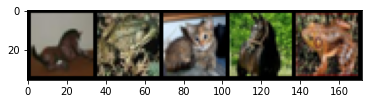

horse, frog, cat, horse, frog


In [ ]:
batch_size = 5

# download the CIFAR-10 dataset from torchvision
CIFAR_trainset = torchvision.datasets.CIFAR10(root='./data', 
                                              train=True,
                                              download=True, 
                                              transform=transforms.ToTensor())

# loading the data to make it compatible with PyTorch
CIFAR_trainloader = torch.utils.data.DataLoader(CIFAR_trainset, 
                                                batch_size=batch_size,
                                                shuffle=True, 
                                                num_workers=2)

CIFAR_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
CIFAR_dataiter = iter(CIFAR_trainloader)
images, labels = CIFAR_dataiter.next()

print("shape of data: {}".format(images[0].shape))

# visualizations
imshow(torchvision.utils.make_grid(images))
print(', '.join(CIFAR_classes[labels[j]] for j in range(batch_size)))


To load the garbage dataset:


1.   Download the dataset from Kaggle.
2.   Upload the dataset archive to your Google Drive home directory.
3.   Run the code blocks below to mount your Drive to Colab and unzip the dataset.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip './drive/MyDrive/archive'

Run the code block below to import the data into the notebook (see [ImageFolder Dataset](https://pytorch.org/vision/stable/datasets.html#imagefolder) for more information).

For training, we split the dataset into train, validation, and test sets.
1. The train set is used to learn the model parameters through optimization against the cost function.
2. The validation set is used during training to ensure we do not overfit to our training data, and to measure hyperparameter performance.
3. The test set is used to evaluate model performance.

shape of data: torch.Size([3, 384, 512])


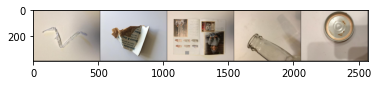

paper, cardboard, paper, glass, metal


In [ ]:
root = './garbage classification/Garbage classification'

garbage_set = torchvision.datasets.ImageFolder(root=root, 
                                               transform=transforms.ToTensor())

garbage_trainset, garbage_valset, garbage_testset = torch.utils.data.random_split(garbage_set, [1616, 404, 507])

garbage_trainloader = torch.utils.data.DataLoader(garbage_trainset, 
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=2)

garbage_valloader = torch.utils.data.DataLoader(garbage_valset, 
                                                batch_size=batch_size,
                                                shuffle=True, 
                                                num_workers=2)

garbage_dataiter = iter(garbage_trainloader)
images, labels = garbage_dataiter.next()

garbage_classes = ('cardboard', 'glass', 'metal',
                   'paper', 'plastic', 'trash')

print("shape of data: {}".format(images[0].shape))

imshow(torchvision.utils.make_grid(images))
print(', '.join(garbage_classes[labels[j]] for j in range(batch_size)))

# Choosing a Model
For computer vision models, a popular architecture is a Convolutional Neural Network (CNN). A CNN contains layers that act as sliding filters that learn condensed representations of images; from there, we can perform classification using a linear model.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

total_params = lambda m: sum(p.numel() for p in m.parameters() if p.requires_grad)

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

print("trainable parameters: {}".format(total_params(net)))

trainable parameters: 62006


Note that this model contains ~60000 parameters.

However, instead of training a model from scratch, we will leverage transfer learning. We can use a pretrained model to offload computation and save time. 

In [ ]:
import torchvision.models as models

model = models.mobilenet_v3_small(pretrained=True)
model.to(dev)
print("trainable parameters: {}".format(total_params(model)))

trainable parameters: 2542856


The MobileNet model has ~2.5 M parameters. Let's visualize the outputs of our model:

Note that we now apply a data pre-processing pipeline. Pre-processing is commonly used to remove noise from the data, engineer interesting features, and make the data compatible with the model. See [torchvision.transforms](https://pytorch.org/vision/0.8/transforms.html) for more information.

In [ ]:
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]),
])

garbage_set = torchvision.datasets.ImageFolder(root=root, 
                                               transform=transform)

garbage_trainset, garbage_valset, garbage_testset = torch.utils.data.random_split(garbage_set, 
                                                                                  [1616, 404, 507])

garbage_trainloader = torch.utils.data.DataLoader(garbage_trainset, 
                                                  batch_size=1,
                                                  shuffle=True, 
                                                  num_workers=2)

garbage_dataiter = iter(garbage_trainloader)

# load ImageNet labels
with open("imagenet_classes.txt", "r") as f:
  imagenet_classes = [s.strip() for s in f.readlines()]

Visualizing on some common image data:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


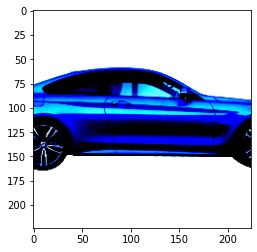

 predicted: sports car


In [ ]:
from PIL import Image

img_path = YOUR_IMAGE_HERE # replace this with any picture you find online!
model.eval()

image = Image.open(img_path)

image = transform(image)
image = torch.unsqueeze(image, 0).to(dev)

# visualize pretrained model outputs
out = torch.argmax(model(image)).item()
image = image.cpu()
imshow(torchvision.utils.make_grid(image))
print(" predicted: {}".format(imagenet_classes[out]))

Visualizing on our dataset:

In [1]:
# visualize pretrained model outputs
for i in range(3):
  image, label = garbage_dataiter.next()
  image, label = image.to(dev), label.to(dev)
  out = torch.argmax(model(image)).item()
  label = label.item()
  image = image.cpu()
  imshow(torchvision.utils.make_grid(image))
  print(" predicted: {}\n".format(imagenet_classes[out]))

NameError: ignored

# Training and Fine-tuning
Note that the pre-trained model is not compatible with our current classification problem. This is because our model was trained on a different task. Note the outputs of our model:

In [ ]:
print(model.classifier[3])

Linear(in_features=1024, out_features=1000, bias=True)


For the trash dataset, we expect 6 outputs corresponding to the probability of each classs for the given input, but the model currently outputs 1000 values! We can fix this by replacing the "head" of the model with a head more suited to our task, and training only the new head (the last layer).

In [ ]:
# freezing the model parameters
for param in model.parameters():
    param.requires_grad = False

# replace the last layer
model.classifier[3] = nn.Linear(in_features=1024, out_features=6)

print(model.classifier[3])
print("trainable parameters: {}".format(total_params(model)))

Linear(in_features=1024, out_features=6, bias=True)
trainable parameters: 6150


Note that we only need to train \~6000 parameters! Compare this with the parameter count for our CNN that would be trained from scratch (\~60000).

Using transfer learning, we are able to leverage stronger networks trained on more amounts of data for our own tasks.

Now, we begin training our modified MobileNet model. Training a model requires several steps:
1. Define the cost function (often using a built in cost function in torch)
2. Define the optimization algorithm (often using a built in algorithm in torch)
3. Run the training loop using gradient descent.

For classifiation problems like ours, it is common to use [Cross Entropy Loss]() as our loss function.

For optimization, some common algorithms are [Batch Gradident Descent](), [Stochastic Gradient Descent](), and [Adam]().

In [ ]:
import torch.optim as optim

# hyperparams include training epochs, batch size, learning rate, and others
num_epochs = 20
batch_size = 128
lr = 0.001

# define cost function - Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# define the optimization algorithm - SGD
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# redefine the TrainLoaders
garbage_trainloader = torch.utils.data.DataLoader(garbage_trainset, 
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=2)

garbage_valloader = torch.utils.data.DataLoader(garbage_valset, 
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=2)

In [ ]:
# training loop:
for epoch in range(num_epochs):
  train_loss = 0.0
  val_loss = 0.0
  acc = 0

  model.train()
  
  # training loop: performing gradient descent
  for i, data in enumerate(garbage_trainloader, 0):      
    inputs, labels = data
    inputs, labels = inputs.to(dev), labels.to(dev)

    optimizer.zero_grad()

    out = model(inputs)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  
  model.eval()

  # calculating model validation loss + accuracy
  for data in garbage_valloader:
    inputs, labels = data
    inputs, labels = inputs.to(dev), labels.to(dev)

    out = model(inputs)
    loss = criterion(out, labels)
    val_loss += loss.item()

    preds = torch.argmax(out, axis=1)
    acc += torch.sum(preds==labels)
    
  print("epoch {}".format(epoch))
  print("  training loss: {}".format(train_loss / len(garbage_trainset)))
  print("  validation loss: {}".format(val_loss / len(garbge_valset)))
  print("  validation accuracy: {}".format(acc / len(garbage_valset)))

print('Finished Training')

epoch 0
  training loss: 0.01402315504775189
  validation accuracy: 0.32425743341445923
epoch 1
  training loss: 0.01266403961004597
  validation accuracy: 0.48762375116348267
epoch 2
  training loss: 0.011290842575011867
  validation accuracy: 0.594059407711029
epoch 3
  training loss: 0.010136916053177106
  validation accuracy: 0.655940592288971
epoch 4
  training loss: 0.00927289486816614
  validation accuracy: 0.6757425665855408
epoch 5
  training loss: 0.008650163686511541
  validation accuracy: 0.6856435537338257
epoch 6
  training loss: 0.00813806363114036
  validation accuracy: 0.6955445408821106
epoch 7
  training loss: 0.007774179192757843
  validation accuracy: 0.7153465151786804
epoch 8
  training loss: 0.007370957864983247
  validation accuracy: 0.7277227640151978
epoch 9
  training loss: 0.007072134994634307
  validation accuracy: 0.7351484894752502
epoch 10
  training loss: 0.006889223572936388
  validation accuracy: 0.7351484894752502
epoch 11
  training loss: 0.0066099

Lastly, performing some predictions with our model and packaging for use.

To measure our model's performance, we use a test set, which are data points held out during training. This measures the model's ability to generalize to the true distribution (i.e. unseen data points).

In [ ]:
model.eval()

garbage_testloader = torch.utils.data.DataLoader(garbage_testset, 
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=2)

total = 0

for data in garbage_testloader:
    inputs, labels = data
    inputs, labels = inputs.to(dev), labels.to(dev)
    out = model(inputs)
    preds = torch.argmax(out, axis=1)
    total += torch.sum(preds==labels)

print("test set accuracy: {}".format(total / len(garbage_testset)))

test set accuracy: 0.7633135914802551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


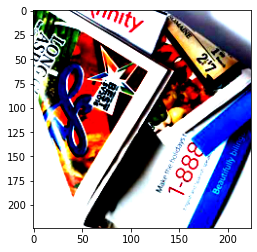

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: paper, predicted: paper


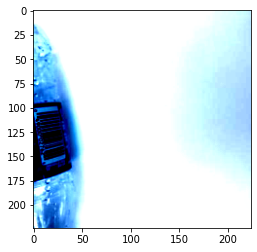

label: plastic, predicted: plastic


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


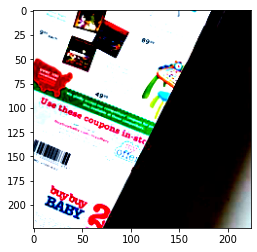

label: paper, predicted: paper


In [ ]:
garbage_testloader = torch.utils.data.DataLoader(garbage_testset, 
                                                  batch_size=1,
                                                  shuffle=True, 
                                                  num_workers=2)

garbage_dataiter = iter(garbage_testloader)

for i in range(3):
  image, label = garbage_dataiter.next()
  image, label = image.to(dev), label.to(dev)

  out = torch.argmax(model(image))
  label = label.item()
  image = image.to("cpu")

  imshow(torchvision.utils.make_grid(image))
  print("label: {}, predicted: {}".format(garbage_classes[label], garbage_classes[out]))

The code below will save our model's parameters. We can load these parameters for future use.

In [ ]:
PATH = './model.pth'
torch.save(net.state_dict(), PATH)